<a href="https://colab.research.google.com/github/hungpham13/Laptop-EDA/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! git clone https://github.com/hungpham13/Laptop-EDA/

Cloning into 'Laptop-EDA'...
remote: Enumerating objects: 278, done.
remote: Counting objects: 100% (278/278), done.
remote: Compressing objects: 100% (213/213), done.
remote: Total 278 (delta 166), reused 133 (delta 61), pack-reused 0
Receiving objects: 100% (278/278), 26.62 MiB | 9.80 MiB/s, done.
Resolving deltas: 100% (166/166), done.


# Welcome to Laptop Market Exploratory Data Analysis !
Here we are going to take a closer look at our Laptop data that was scraped from 3 main websites: fptshop.com.vn, cellphones.com and thegioididong.com.vn. 


---


In this section, we will be analysing our data in a variety of aspect: 
+ The most important attributes to follow along is "*Comment_count*" (number of comments on each product, summarized from all 3 sources), "*Rating*" (Rating score on scale 5 for each laptop) and the last one is "*Rating_count*" (number of feedback given on each laptop).
  + *Comment_count* represents the crowd attention or popularity of a product.
  + *Rating* and *Rating_count* represent how good or bad the product is, or how satisfactory customer feels with that product. 
+ For more precise look and better insights, we will need to examine some other attributes ralated to the technological details of our products such as:
  + *Price*: the sale price of each laptop
  + *Series* and *Brand*: Name of laptop's brand and particular series 
  + *cpu_brand* and *cpu_code*: Name of laptop CPU's producer and series
  +  ['hdmi', 'backlit_keyboard', 'lan', 'ram_upgradable', 'sd_card',      'storage_extra_slot', 'headphone_jack', 'type_c', 'usb_a']: Informations about supported hardwares
  + And many other technological informations
+ We will divide the analysis into 3 main sections: 
  + Import data and preprocessing
  + Examine Numerical Attributes, which focus on the distributions of importants attributes and determine the relationship with other numerical columns.
  + Examine Categorical Attributes, which focus on the categories distribution and chi-square test to determine if an attribute affects others.

**NOTE: REMOVE OUTLIER OF NUMERIC ATT**

## I. Import libraries, Data and prepare data


---

Our data preparing includes importing data, drop unnecessary columns, handle missing value and prepare numerical/categorical attributes.

In [3]:
#@title Importing libraries
#@markdown In our Analysis today, we will mostly use matplotlib and seaborn library for ploting data; scipy library is also needed for calculating entropy and chisquare statistics - we will see in the third section.

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline
import seaborn as sns

import pandas as pd
from pandas.api.types import is_numeric_dtype

import warnings
warnings.filterwarnings('ignore')

!pip install scipy
import scipy
from scipy.stats import chi2_contingency, entropy

In [30]:
#@title Importing data
#@markdown File name: `marged_data.csv`

#@markdown Here we notice that the original indexes from scraped data are not useful anymore, so we should drop them. Without dropping those columns, our data later on wil have noise in calculating correlation as well as numerical attributes analysis.
main_data = pd.read_csv('./Laptop-EDA/merged_data.csv')
main_data = main_data.drop('Index_fpt', axis = 1)
main_data = main_data.drop('Index_cellphones', axis = 1)
main_data = main_data.drop('Index_tgdd', axis = 1)
main_data = main_data.drop('Unnamed: 0', axis = 1)
main_data = main_data.drop('P/N', axis = 1)
# main_data = main_data.drop('Series', axis = 1)
main_data.head()

,GPU,Comment_count,Price,Rating,Rating_count,Series,Brand,cpu_brand,cpu_code,ram_size,storage_size,displ_size,displ_rate,Battery,OS,displ_resolution,hdmi,Release_year,Surface,Weight,backlit_keyboard,lan,length,ram_upgradable,screen_technology,sd_card,storage_extra_slot,storage_type,headphone_jack,thickness,type_c,usb_a,width,Availabe_in
0,nvidia geforce rtx 3050 ti,906.0,2.862633e+07,0.0,0.0,nitro 5 gaming an515 57 74nu nh.qd9sv.001,acer,intel,11800h,8.0,512.0,15.6,144.0,57.0,windows 10,1920 x 1080,yes,2021.0,plastic,2.20,yes,yes,363.40,yes,ips,no,yes,ssd,yes,23.9,yes,yes,255.00,3
1,nvidia geforce mx450,400.0,2.125967e+07,0.0,0.0,gaming modern 14 b11sbu 669vn,msi,intel,1155g7,8.0,512.0,14.0,60.0,39.0,windows 10,1920 x 1080,yes,2021.0,metal,1.30,yes,no,319.00,yes,ips,yes,no,ssd,yes,16.9,yes,yes,219.00,3
2,intel uhd graphics,322.0,1.529450e+07,3.7,18.0,inspiron 15 3511 p112f001abl,dell,intel,1115g4,4.0,256.0,15.6,60.0,41.0,windows 10,1920 x 1080,yes,2021.0,plastic,1.70,no,no,358.50,yes,va,yes,yes,ssd,yes,18.9,no,yes,235.50,2
3,intel uhd graphics,378.0,1.499900e+07,5.0,4.0,ideapad slim 3 15itl6 82h80040vn,lenovo,intel,1115g4,8.0,512.0,15.6,60.0,NaN,windows 10,1920 x 1080,yes,2021.0,plastic,1.65,yes,yes,359.00,yes,led,yes,yes,ssd,yes,19.9,yes,yes,237.70,1
4,intel iris xe graphics,1244.0,1.879900e+07,5.0,5.0,ideapad slim 5 15itl05 82fg00r0vn,lenovo,intel,1135g7,16.0,512.0,15.6,60.0,45.0,windows 10,1920 x 1080,yes,2021.0,"metal, plastic",1.66,yes,yes,356.67,yes,ips,yes,yes,ssd,yes,17.9,yes,yes,233.13,1


In [6]:
main_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 552 entries, 0 to 551
Data columns (total 34 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   GPU                 548 non-null    object 
 1   Comment_count       552 non-null    float64
 2   Price               496 non-null    float64
 3   Rating              552 non-null    float64
 4   Rating_count        552 non-null    float64
 5   Series              552 non-null    object 
 6   Brand               552 non-null    object 
 7   cpu_brand           552 non-null    object 
 8   cpu_code            552 non-null    object 
 9   ram_size            552 non-null    float64
 10  storage_size        552 non-null    float64
 11  displ_size          552 non-null    float64
 12  displ_rate          552 non-null    float64
 13  Battery             489 non-null    float64
 14  OS                  548 non-null    object 
 15  displ_resolution    545 non-null    object 
 16  hdmi    

---------- Numeric attributes---------------
Comment_count    256
Price            351
Rating            49
Rating_count      51
displ_size        19
Battery           59
Weight           113
length           127
thickness        104
width            148
dtype: int64
---------- Categorical attributes---------------
GPU                    52
Series                520
Brand                  13
cpu_brand               3
cpu_code               67
ram_size                5
storage_size            7
displ_rate              8
OS                      4
displ_resolution       23
hdmi                    2
Release_year            5
Surface                 9
backlit_keyboard        2
lan                     2
ram_upgradable          2
screen_technology       6
sd_card                 2
storage_extra_slot      2
storage_type            3
headphone_jack          2
type_c                  2
usb_a                   2
Availabe_in             3
dtype: int64


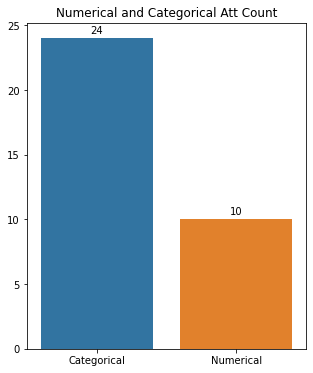

In [29]:
#@title Identify cagetorical and numeric variables

numeric_attributes = main_data[[c for c in main_data.columns 
                                if main_data[c].value_counts().count() > 15 
                                and is_numeric_dtype(main_data[c])]]
print('---------- Numeric attributes---------------')
print(numeric_attributes.nunique())

categorical_attributes = main_data[[c for c in main_data.columns if c not in numeric_attributes.columns]]
print('---------- Categorical attributes---------------')
print(categorical_attributes.nunique())

fig = plt.figure(figsize=(5,6))
y = [len(categorical_attributes.columns), len(numeric_attributes.columns)]
ax = sns.barplot(['Categorical', 'Numerical'], y)
ax.set_title('Numerical and Categorical Att Count')
for p in ax.patches:
    ax.annotate(int(p.get_height()), 
                    xy = (p.get_x() + p.get_width() /2, p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 8), 
                    textcoords = 'offset points')

In [8]:
#@title Fill null
#@markdown After checking the information of the remaining data, there are a lot of columns that still have null value. To handle this, we might choose either to drop all the missing row or to fill in the null values with appropriate value. 

#@markdown Since our data is quite small in size, dropping all rows with null value is wasting information so filling in the missing value should be considered. For numerical attributes, we fill null by the mean of that columns. For categorical attributes, we simply replace null with "NaN"

for att in numeric_attributes.columns:
    main_data[att].fillna(main_data[att].mean(), inplace = True)
# ????
# for att in categorical_attributes.columns:
#     main_data[att].fillna('NaN', inplace = True)

In [9]:
#@title Remove outliers



In [10]:
#@title Normalize Rating_count and Comment_count
main_data['Comment_count'] = main_data['Comment_count']/main_data['Availabe_in']
main_data['Rating_count'] = main_data['Rating_count']/main_data['Availabe_in']

## II. Analysis of Numerical Attributes

---


For numerical attributes, the first thing to pay attention is the distribution of that attributes, and the distribution among multiple attributes. From there, we can explore and come up with deep knowledge of our data. In this section, we will plot out some statistics of the most important properties to know better about our data's balance, relation and deduce some conclusion.

First, let's take a look on the ratio of numerical - categorical attributes in our column set.

Our data seems to have more categorical data than numerical ones. This may comes from the variety of hardware information and brand naming. However, the different in number of 2 attribute types is not too big.

We will head up to the distribution visualize of some important attributes: *Comment_count*, *Rating*, *Rating_count* and *Price*

In [11]:
def plot_statistics(df: pd.DataFrame, bins = 10, title = None):
    fig, (ax_box, ax_hist) = plt.subplots(2, sharex= True, gridspec_kw={"height_ratios": (.15, .85)})
    fig.set_figheight(5)
    fig.set_figwidth(10)
    ax_box.set_title(title)
    sns.boxplot(df, ax=ax_box)
    sns.distplot(df, ax=ax_hist, bins = bins)
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)

In [12]:
#Take a look at the number format of each attributes
primary_attributes = main_data[['Comment_count', 'Rating', 'Rating_count']]
price = main_data.Price
for col in primary_attributes.columns:
    print(primary_attributes[col].unique())

[3.02000000e+02 1.33333333e+02 1.61000000e+02 3.78000000e+02
 1.24400000e+03 5.58000000e+02 1.77000000e+02 3.20000000e+01
 6.50000000e+01 2.68000000e+02 1.65000000e+02 4.21000000e+02
 5.70000000e+01 2.70000000e+01 8.00000000e+00 5.40000000e+01
 2.23000000e+02 6.00000000e+00 1.50000000e+01 3.80000000e+01
 0.00000000e+00 4.00000000e+00 1.00000000e+00 3.00000000e+01
 1.90000000e+01 1.00000000e+01 4.40000000e+01 6.00000000e+01
 1.20000000e+01 5.60000000e+01 9.90000000e+01 3.17000000e+02
 3.29000000e+02 1.04000000e+02 5.30000000e+01 2.40000000e+01
 1.70000000e+01 3.30000000e+01 4.31000000e+02 2.00000000e+00
 2.30000000e+01 3.10000000e+01 2.12000000e+02 2.09000000e+02
 9.69000000e+02 7.50000000e+01 2.80000000e+01 3.97000000e+02
 1.85500000e+02 4.60000000e+01 1.80000000e+01 2.90000000e+01
 1.60000000e+01 1.64500000e+02 2.50000000e+01 1.09000000e+02
 4.20000000e+01 1.88500000e+02 1.78000000e+02 1.47000000e+02
 1.58950000e+03 3.38500000e+02 5.00000000e+00 4.10000000e+01
 2.00000000e+01 6.900000

count    5.520000e+02
mean     2.675048e+07
std      1.226619e+07
min      7.290000e+06
25%      1.876950e+07
50%      2.499000e+07
75%      3.007288e+07
max      9.299000e+07
Name: Price, dtype: float64


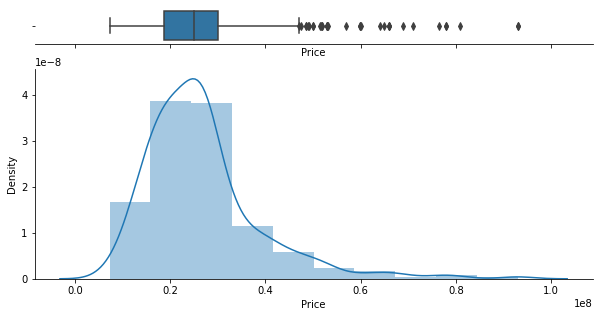

In [13]:
#Summarize some statistics information of Price and plot the distribution
print(price.describe())
plot_statistics(price)

As the plot tells, this attribute *Price* has many outliers beyond the 75% quantiles. Another point told is that the distribution of price over all product is not located at the middle but is left-shifted.

The most common price lies between 20.000.000 to 30.000.000 VND. (~ 1000 - 1500 USD)

The lowest price to afford a laptop from those sites is 7.000.000 VND (~ 350 USD) and the most luxury laptop costs ~ 93.000.000 VND (~ 4500 USD)

For further exploration, we will divide the price to 3 dimension: low, average and high by the quantile (0, 0.33, 0.67, 1.00)

In [14]:
low_price = main_data[main_data['Price'] < main_data['Price'].quantile(0.33)]
avr_price = main_data[(main_data['Price'] > main_data['Price'].quantile(0.33)) &  
                          (main_data['Price'] < main_data['Price'].quantile(0.67))]
high_price = main_data[main_data['Price'] > main_data['Price'].quantile(0.67)]
ultra_high_price = 0

low_price = main_data[main_data['Price'] < (main_data['Price'].min() + main_data['Price'].max())/3] 
avr_price = main_data[(main_data['Price'] > main_data['Price'].quantile(0.25)) & 
                          (main_data['Price'] < main_data['Price'].quantile(0.75))]
high_price = main_data[main_data['Price'] > main_data['Price'].quantile(0.75)]
print('low_price:  {} \navr_price:  {} \nhigh_price: {}'.format(len(low_price), len(avr_price), len(high_price)))
print('low_price:  {} \navr_price:  {} \nhigh_price: {}'.format(len(low_price), len(avr_price), len(high_price)))


low_price:  447 
avr_price:  276 
high_price: 138
low_price:  447 
avr_price:  276 
high_price: 138


Low price dimension statistics:  count    4.470000e+02
mean     2.211833e+07
std      5.897602e+06
min      7.290000e+06
25%      1.780500e+07
50%      2.249000e+07
75%      2.675048e+07
max      3.339000e+07
Name: Price, dtype: float64
Average price dimension statistics:  count    2.760000e+02
mean     2.451907e+07
std      3.137190e+06
min      1.879300e+07
25%      2.168238e+07
50%      2.499000e+07
75%      2.675048e+07
max      3.006900e+07
Name: Price, dtype: float64
High price dimension statistics:  count    1.380000e+02
mean     4.296726e+07
std      1.278313e+07
min      3.008450e+07
25%      3.354338e+07
50%      3.904650e+07
75%      4.710850e+07
max      9.299000e+07
Name: Price, dtype: float64


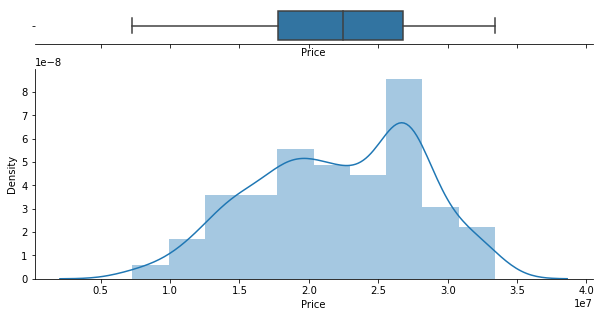

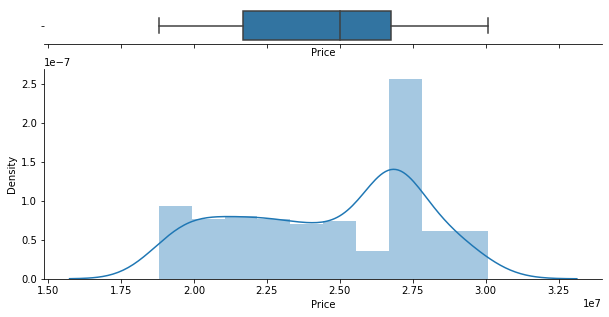

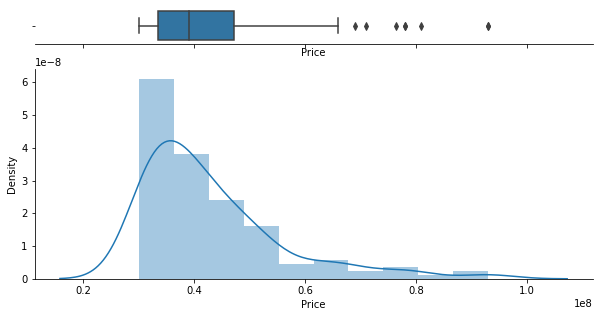

In [15]:
#Plot statistics for each price dimension
plot_statistics(low_price['Price'])
print('Low price dimension statistics: ', low_price['Price'].describe())
plot_statistics(avr_price['Price'])
print('Average price dimension statistics: ', avr_price['Price'].describe())
plot_statistics(high_price['Price'])
print('High price dimension statistics: ', high_price['Price'].describe())

With our 3 primary attributes of concern, distribution of each feature is also needed along with the statistics information.

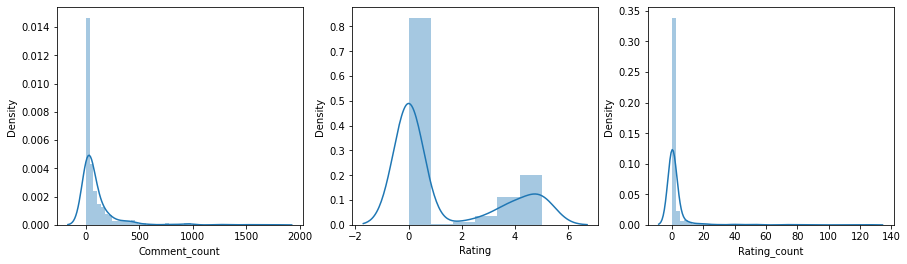

In [16]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (15,4))
for i, att in enumerate(primary_attributes.columns):
    sns.distplot(primary_attributes[att], ax = ax[i])

Taken the very first look at the Density plot of 3 above features, it can be seen clearly that these features are significantly imbalance. The maximum values of *Comment_count* and *Rating_count* lies far beyond the center distribution and almost remain values lies near 0.

We will examine each of the attributes in statistics and histogram plot to get a better look.

The first attributes is *Comment_count*:

In [17]:
comment_count = main_data.Comment_count 
comment_count.describe()

count     552.000000
mean      102.116244
std       197.811320
min         0.000000
25%        11.000000
50%        33.000000
75%       104.250000
max      1756.000000
Name: Comment_count, dtype: float64

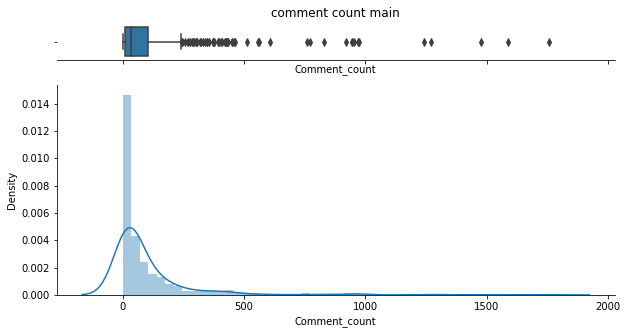

In [18]:
plot_statistics(main_data.Comment_count, bins = 50, title = 'comment count main')

Almost all comment count on product are from 0 to 140 comments (75% quantile), but some products seems to be controversial and has so much comment (1756 comments count). Checking that outliers might be useful for enhancing sale experience, but not really help in general analysis, so we will head to the next attributes *Rating*.

In [19]:
main_data.Rating.describe()

count    552.000000
mean       1.285626
std        2.004994
min        0.000000
25%        0.000000
50%        0.000000
75%        3.505000
max        5.000000
Name: Rating, dtype: float64

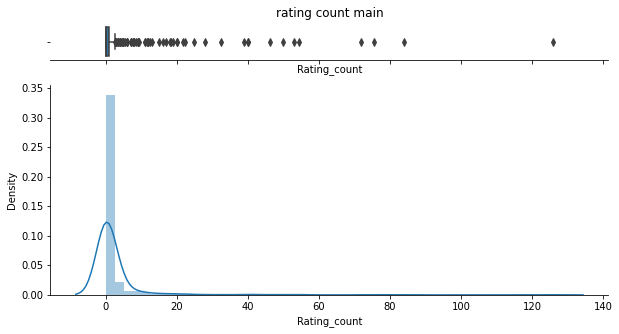

In [20]:
plot_statistics(main_data.Rating_count, bins = 50, title = 'rating count main')

<BarContainer object of 3 artists>

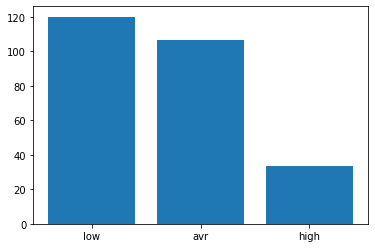

In [21]:
x = ['low', 'avr', 'high']
y = [low_price['Comment_count'].mean(), avr_price['Comment_count'].mean(), high_price['Comment_count'].mean()]
plt.bar(x,y)

<BarContainer object of 3 artists>

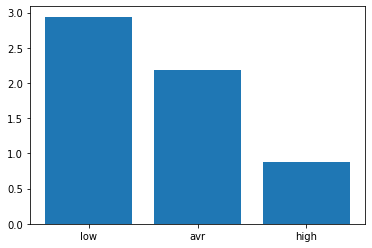

In [22]:
plt.bar(['low', 'avr', 'high'],
        [low_price['Rating_count'].mean(), avr_price['Rating_count'].mean(), high_price['Rating_count'].mean()])

In [23]:
rating = main_data.Rating
rating.describe()

count    552.000000
mean       1.285626
std        2.004994
min        0.000000
25%        0.000000
50%        0.000000
75%        3.505000
max        5.000000
Name: Rating, dtype: float64

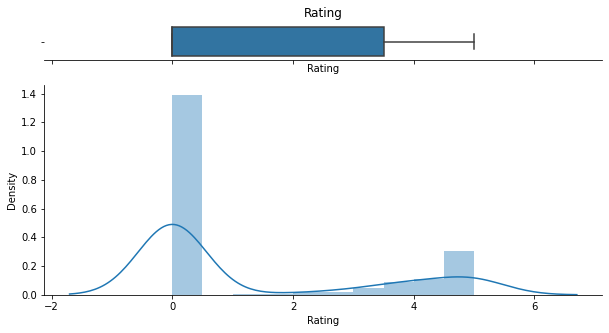

In [24]:
plot_statistics(rating, title = 'Rating')

In [25]:
rating_count = main_data.Rating_count
rating_count.describe()

count    552.000000
mean       2.551932
std        9.917868
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max      126.000000
Name: Rating_count, dtype: float64

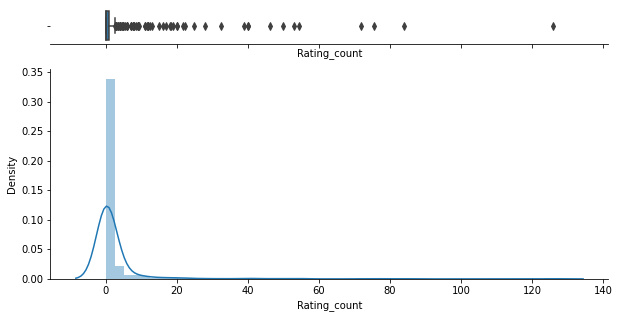

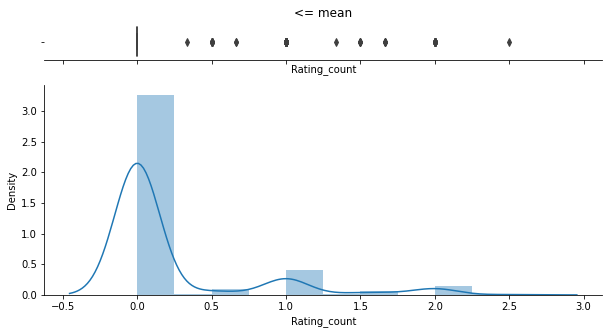

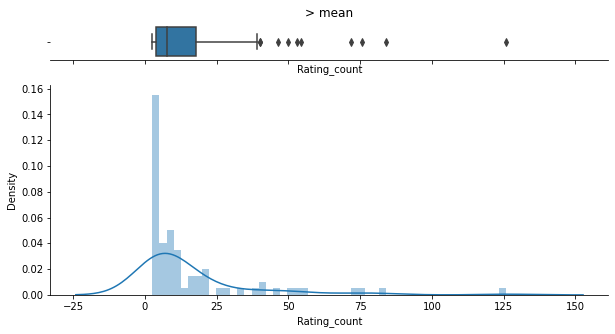

In [26]:
plot_statistics(rating_count, bins = 50)
plot_statistics(rating_count[rating_count <= rating_count.mean()], bins = 10, title = '<= mean')
plot_statistics(rating_count[rating_count > rating_count.mean()], bins = 50, title = '> mean')

Comment_count    4.489935
Price            1.858115
Rating           1.009320
Rating_count     7.205786
ram_size         1.842154
storage_size     2.383553
displ_size       3.270010
displ_rate       2.255884
Battery          3.678874
Release_year    -2.420211
Weight           4.559104
length           3.268369
thickness        9.985164
width            1.891313
Availabe_in      1.551769
dtype: float64

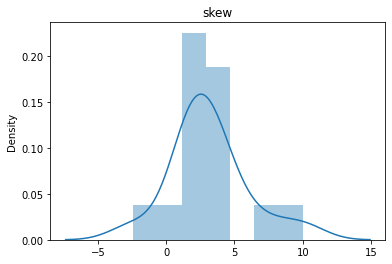

In [27]:
ax = sns.distplot(main_data.skew())
ax.set_title('skew')
main_data.skew()

In [28]:
normalized_numeric_attributes = (numeric_attributes - numeric_attributes.mean())/numeric_attributes.std()
correlation = normalized_numeric_attributes.drop('Availabe_in', axis = 1).corr()
f , ax = plt.subplots(figsize = (14,12))
sns.heatmap(correlation, square = True, annot = True)

KeyError: ignored

In [ ]:
fig, ax = plt.subplots(figsize = (30,9), nrows = 1, ncols = 3)
k = 8
count = 0
list_attributes = [low_price, avr_price, high_price]
for j in range(len(list_attributes)):
    att = list_attributes[j]
    att['Comment_count'] = att['Comment_count']/att['Availabe_in']
    att['Rating_count'] = att['Rating_count']/att['Availabe_in']
    normalized_att = (att - att.mean())/att.std()
    correlation = normalized_att.drop('Availabe_in', axis = 1).corr()
    cols = correlation.abs().nlargest(k, 'Comment_count').index
    zoomed_corr = np.corrcoef(main_data[cols].values.T)
    sns.heatmap(zoomed_corr,square=True,cmap='viridis', linewidths=0.01,linecolor="white",annot=True,
        xticklabels = cols.values ,yticklabels = cols.values, ax = ax[j], annot_kws = {'size':8})

In [ ]:
sns.set()
cols = correlation.nlargest(k, 'Comment_count').index
#cols = numeric_attributes.columns
print(cols)
sns.pairplot(main_data[cols],size = 2 ,kind ='scatter',diag_kind='kde')
plt.show()

In [ ]:
att_list = ['Weight', 'Comment_count', 'ram_size', 'storage_size']
fig, axis = plt.subplots(len(att_list), len(att_list),figsize=(20, 16))
for i in range(len(att_list)):
    for j in range(len(att_list)):
        var1 = att_list[i]
        var2 = att_list[j]
        if var1 == 'Rating':
            var1_data = main_data[var1].round()
        else: 
            var1_data = main_data[var1].round()
        data = pd.concat([main_data[var2], var1_data], axis=1)
        try:
          sns.boxplot(x = var1, y = var2, data = data, ax = axis[i,j])
        except:
          continue

In [ ]:
var = 'Rating'
var_data = main_data[var].round()
data = pd.concat([main_data['Comment_count'], var_data], axis=1)
f, ax = plt.subplots(figsize=(12, 8))
fig = sns.boxplot(x=var, y="Comment_count", data=data)

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (20, 7), sharey = True)
plt.xticks(rotation=90)
for i, att in enumerate(primary_attributes):
    ax[i].plot(correlation[att])
    ax[i].set_xticklabels(labels = correlation.columns,rotation=45, ha='right')

In [ ]:
categorical_attributes.columns

In [ ]:
categorical_attributes.nunique()

In [ ]:
brand = categorical_attributes['Brand']
cpu = categorical_attributes['cpu_brand']
gpu = categorical_attributes['GPU']
os = categorical_attributes['OS']
screen_tech = categorical_attributes['screen_technology']
storage_type = categorical_attributes['storage_type']
binary_attributes = ['hdmi', 'backlit_keyboard', 'lan', 'ram_upgradable', 'sd_card', 
                     'storage_extra_slot', 'headphone_jack', 'type_c', 'usb_a']

entro = []
for att in categorical_attributes:
    entro.append(entropy(categorical_attributes[att].value_counts()))
plot = plt.figure(figsize = (20,7))
plt.bar(categorical_attributes.columns, entro)
plt.xticks(rotation = 45)

In [ ]:
brand_count = brand.value_counts()
plot = plt.figure(figsize = (10, 7))
sns.barplot(brand_count.index, brand_count.values, alpha=0.9)
plt.title('Brands Count')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Brand', fontsize=12)
plt.show()

In [ ]:
cpu_brand_count = cpu.value_counts()
plot = plt.figure(figsize = (10, 7))
sns.barplot(cpu_brand_count.index, cpu_brand_count.values, alpha=0.9)
plt.title('CPU Brands Count')
plt.ylabel('Count', fontsize=12)
plt.xlabel('CPU Brand', fontsize=12)
plt.show()

In [ ]:
os_count = os.value_counts()
plot = plt.figure(figsize = (10, 7))
sns.barplot(os_count.index, os_count.values, alpha=0.9)
plt.title('OS Count')
plt.ylabel('Count', fontsize=12)
plt.xlabel('OS', fontsize=12)
plt.show()

In [ ]:
plot = plt.figure(figsize = (10, 7))
sns.barplot(main_data['Comment_count'].groupby(brand).mean().index, 
            main_data['Comment_count'].groupby(brand).mean(), alpha=0.9)
plt.title('Comment by brands Count')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Brand', fontsize=12)
plt.show()

In [ ]:
plot = plt.figure(figsize = (10, 7))
sns.barplot(main_data['Comment_count'].groupby(cpu).mean().index, 
            main_data['Comment_count'].groupby(cpu).mean(), alpha=0.9)
plt.title('Comment by CPU brands Count')
plt.ylabel('Count', fontsize=12)
plt.xlabel('CPU', fontsize=12)
plt.show()

In [ ]:
plot = plt.figure(figsize = (10, 7))
sns.barplot(main_data['Comment_count'].groupby(os).mean().index, 
            main_data['Comment_count'].groupby(os).mean(), alpha=0.9)
plt.title('Comment by OS Count')
plt.ylabel('Count', fontsize=12)
plt.xlabel('OS', fontsize=12)
plt.show()

In [ ]:
var_data = brand
data = pd.concat([main_data['Price'], var_data], axis=1)
f, ax = plt.subplots(figsize=(12, 8))
fig = sns.boxplot(x= 'Brand', y="Price", data=data)

In [ ]:
var_data = brand
data = pd.concat([main_data['Comment_count'], var_data], axis=1)
print(data.head())
f, ax = plt.subplots(figsize=(12, 8))
fig = sns.boxplot(x= 'Brand', y="Comment_count", data=data)

In [ ]:
chi2_list = []
p_list = []
for att in binary_attributes:
    obs = pd.crosstab(index=main_data['Rating'].round(), columns = main_data[att])
    chi2, p, dof, ex = chi2_contingency(obs, correction=False)
    chi2_list.append(chi2)
    p_list.append(p)
plt.bar(binary_attributes, chi2_list)
plt.xticks(rotation = 45)

In [ ]:
chi2_list = []
p_list = []
for att in binary_attributes:
    obs = pd.crosstab(index=main_data['Comment_count'].round(-2), columns = main_data[att])
    chi2, p, dof, ex = chi2_contingency(obs, correction=False)
    chi2_list.append(chi2)
    p_list.append(p)
plt.bar(binary_attributes, chi2_list)

In [ ]:
chi2_list = []
p_list = []
for att in binary_attributes:
    obs = pd.crosstab(index=main_data['Price'].round(-7), columns = main_data[att])
    chi2, p, dof, ex = chi2_contingency(obs, correction=False)
    chi2_list.append(chi2)
    p_list.append(p)
plt.bar(binary_attributes, chi2_list)

TODO:
- Tách riêng significant outlier để phân tích (Comment_count, Rating_count)
  - Remove outlier của những cái còn lại.
- Chia lại khoảng giá (chia theo mức giá): thêm ultra high và chia theo giá
+ Chia lại Numeric - Categoric (Hưng) ✅
+ Numerical Analysis: (với từng khoảng giá) (Hưng)

Chú trọng sự phụ thuộc của các attribute chính vào các numeric att còn lại (Dựa trên correlation + box/line plot)
+ Categorical: (**LẬP**)
  + Dùng bar hoặc pie để xác định tỉ lệ các máy của mỗi cate
  + dùng box hoặc bar để so sánh các att chính của mỗi cate (ví dụ: so sánh cooment count của các dòng OS hoặc so sánh phân pphoois comment_count của các dòng OS)
  + chi2 test, đưa ra hypo và kết luận
+ Spotlight: chọn top 100 để đánh giá các yếu tố tạo nên sự nổi bật. (Nhật)
